# MPV17
[Mitochondrial DNA depletion syndrome-6 (MTDPS6), also known as Navajo neurohepatopathy (NNH)](https://omim.org/entry/256810) is caused by homozygous or compound heterozygous mutation in the MPV17 gene .

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'MPV17'
mane_tx_id = 'NM_002437.5'
mane_protein_id = 'NP_002428.1' 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.24' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 60/60 [00:03<00:00, 17.70 individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #17
    phenotype-features
     errors:
     ·Terms should not contain both present Depletion of mitochondrial DNA in liver [HP:0006581] and its present or excluded ancestor Mitochondrial depletion [HP:0030059]
  patient #32
    phenotype-features
     errors:
     ·Terms should not contain both present Depletion of mitochondrial DNA in liver [HP:0006581] and its present or excluded ancestor Mitochondrial depletion [HP:0030059]
     ·Terms should not contain both present Depletion of mitochondrial DNA in muscle tissue [HP:0009141] and its present or excluded ancestor Mitochondrial depletion [HP:0030059]
  patient #47
    phenotype-features
     errors:
     ·Terms should not contain both present Depletion of mitochondrial DNA in liver [HP:0006581] and its present or excluded ancestor Mitochondrial depletion [HP:0030059]
  

In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
34,Hepatic failure
29,Increased circulating lactate concentration
25,Hypoglycemia
24,Hepatomegaly
23,Failure to thrive
21,Elevated circulating alanine aminotransferase concentration
21,Elevated circulating aspartate aminotransferase concentration
21,Hypotonia
19,Global developmental delay
16,Hepatic steatosis


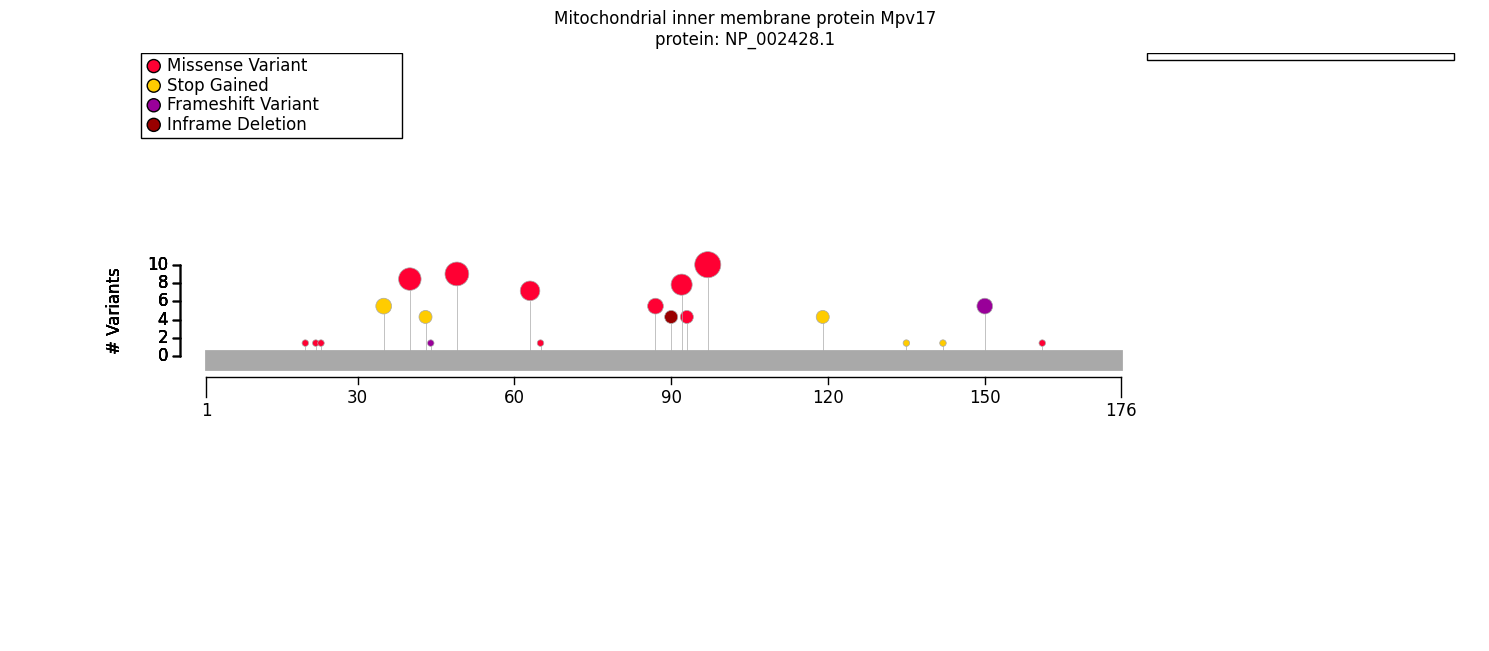

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

mpv17_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
mpv17_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
10,2_27312576_27312576_G_A,c.293C>T (p.Pro98Leu),5,missense
8,2_27313031_27313031_C_T,c.149G>A (p.Arg50Gln),3,missense
5,2_27312768_27312768_G_C,c.191C>G (p.Pro64Arg),4,missense
5,2_27313059_27313059_G_A,c.121C>T (p.Arg41Trp),3,missense
5,2_27312681_27312681_T_G,c.278A>C (p.Gln93Pro),4,"missense, splice region"
4,SO:1000029_HGNC:7224_MPV17,SV involving MPV17 (p.?),,chromosomal deletion
3,2_27311908_27311908_A_AG,c.451dup (p.Leu151ProfsTer39),7,frameshift
2,2_27311898_27311898_C_G,c.461+1G>C (-),-,splice donor
2,2_27312589_27312589_C_G,c.280G>C (p.Gly94Arg),5,"missense, splice region"
2,2_27312685_27312688_CCAA_C,c.271_273del (p.Leu91del),4,inframe deletion


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = biallelic_classifier(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                    partitions=((0,1),(2,))
                                   )
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,1
"Skipping ""general"" level terms",106
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),265


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/missense OR missense/other,other/other,Corrected p values,p values
Global developmental delay [HP:0001263],9/30 (30%),10/14 (71%),0.654371,0.020449
Hypoglycemia [HP:0001943],13/29 (45%),12/16 (75%),0.875318,0.066106
Failure to thrive [HP:0001508],11/24 (46%),12/16 (75%),0.875318,0.104284
Hepatomegaly [HP:0002240],15/25 (60%),9/10 (90%),0.875318,0.119664
Peripheral neuropathy [HP:0009830],14/27 (52%),2/10 (20%),0.875318,0.136768
Elevated circulating alanine aminotransferase concentration [HP:0031964],11/14 (79%),10/10 (100%),1.000000,0.239130
Elevated circulating aspartate aminotransferase concentration [HP:0031956],11/14 (79%),10/10 (100%),1.000000,0.239130
Peripheral axonal neuropathy [HP:0003477],4/17 (24%),0/8 (0%),1.000000,0.268933
Cirrhosis [HP:0001394],9/23 (39%),2/9 (22%),1.000000,0.441376
Hepatic failure [HP:0001399],22/30 (73%),13/15 (87%),1.000000,0.455583


In [10]:
from gpsea.analysis.predicate import variant_key

p98l = variant_key(key="2_27312576_27312576_G_A") # c.293C>T, p.Pro98Leu
p98l_predicate = biallelic_classifier(a_predicate=p98l, 
                                   b_predicate=~p98l, 
                                   a_label="Pro98Leu",
                                   b_label="other",
                                    partitions=((0,),(2,1))
                                   )
p98l_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=p98l_predicate,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=p98l_result)


Allele group,Pro98Leu/Pro98Leu,other/other OR Pro98Leu/other,Corrected p values,p values
Peripheral axonal neuropathy [HP:0003477],3/3 (100%),1/22 (5%),0.036522,0.001739
Peripheral neuropathy [HP:0009830],3/3 (100%),13/34 (38%),0.756757,0.072072
Global developmental delay [HP:0001263],0/3 (0%),19/41 (46%),1.000000,0.246829
Failure to thrive [HP:0001508],0/1 (0%),23/39 (59%),1.000000,0.425000
Abnormal prothrombin time [HP:0032199],1/1 (100%),12/27 (44%),1.000000,0.464286
Hepatic steatosis [HP:0001397],1/1 (100%),19/26 (73%),1.000000,1.000000
Elevated circulating alanine aminotransferase concentration [HP:0031964],1/1 (100%),20/23 (87%),1.000000,1.000000
Elevated circulating aspartate aminotransferase concentration [HP:0031956],1/1 (100%),20/23 (87%),1.000000,1.000000
Mitochondrial depletion [HP:0030059],1/1 (100%),23/23 (100%),1.000000,1.000000
Abnormality of mitochondrial metabolism [HP:0003287],1/1 (100%),24/24 (100%),1.000000,1.000000


In [11]:
arg50gln = variant_key(key="2_27313031_27313031_C_T") # c.149G>A; p.Arg50Gln
arg50gln_clf = biallelic_classifier(a_predicate=arg50gln, 
                                    b_predicate=~arg50gln, 
                                    a_label="Arg50Gln",
                                    b_label="other",
                                    partitions=((0,1),(2,))
                                   )
arg50gln_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=arg50gln_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=arg50gln_result)

Allele group,Arg50Gln/Arg50Gln OR Arg50Gln/other,other/other,Corrected p values,p values
Cirrhosis [HP:0001394],6/8 (75%),5/24 (21%),0.287055,0.009898
Hypotonia [HP:0001252],2/6 (33%),25/33 (76%),0.640346,0.060091
Peripheral neuropathy [HP:0009830],5/6 (83%),11/31 (35%),0.640346,0.066243
Global developmental delay [HP:0001263],1/7 (14%),18/37 (49%),0.854875,0.119369
Hepatomegaly [HP:0002240],3/7 (43%),21/28 (75%),0.854875,0.171455
Prolonged prothrombin time [HP:0008151],2/2 (100%),11/28 (39%),0.854875,0.179310
Abnormal prothrombin time [HP:0032199],2/2 (100%),11/26 (42%),0.854875,0.206349
Increased circulating lactate concentration [HP:0002151],0/1 (0%),29/39 (74%),0.996875,0.275000
Hepatic failure [HP:0001399],6/6 (100%),29/39 (74%),1.000000,0.312157
Elevated circulating alanine aminotransferase concentration [HP:0031964],4/5 (80%),17/19 (89%),1.000000,0.521245


In [12]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Global developmental delay [HP:0001263],7/23 (30%),12/21 (57%),1.0,0.127073
Hypoparathyroidism [HP:0000829],0/12 (0%),3/12 (25%),1.0,0.217391
Hepatic failure [HP:0001399],16/23 (70%),19/22 (86%),1.0,0.283666
Failure to thrive [HP:0001508],11/22 (50%),12/18 (67%),1.0,0.347564
Episodic vomiting [HP:0002572],1/11 (9%),5/16 (31%),1.0,0.349684
Hepatic steatosis [HP:0001397],9/14 (64%),11/13 (85%),1.0,0.384541
Vomiting [HP:0002013],4/13 (31%),7/13 (54%),1.0,0.428308
Cirrhosis [HP:0001394],6/14 (43%),5/18 (28%),1.0,0.465055
Elevated circulating alanine aminotransferase concentration [HP:0031964],12/13 (92%),9/11 (82%),1.0,0.576087
Elevated circulating aspartate aminotransferase concentration [HP:0031956],12/13 (92%),9/11 (82%),1.0,0.576087


In [13]:
from gpsea.analysis.temporal.endpoint import disease_onset, death
from gpsea.analysis.temporal import SurvivalAnalysis
from gpsea.analysis.temporal.stats import LogRankTest

endpoint = death()
survival_statistic = LogRankTest()

survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
p98l_mortality_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=p98l_predicate,
    endpoint=endpoint,
)
print(f"Survival analysis, Pro98Leu, p={p98l_mortality_result.pval:.4f}")

Survival analysis, Pro98Leu, p=0.0096


/tmp/ipykernel_31819/2124046109.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


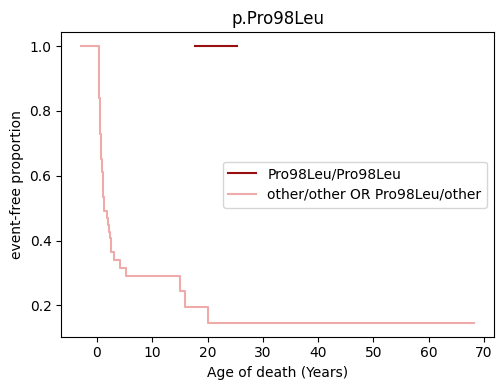

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from gpsea.model import Age

mpv17_mortality_fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.xaxis.set(
    # Show X axis in years ...
    major_formatter=mpl.ticker.FuncFormatter(lambda x, pos: f"{x / Age.DAYS_IN_YEAR:.0f}"),
    # ... with a tick for every decade
    major_locator=mpl.ticker.MultipleLocator(10 * Age.DAYS_IN_YEAR),
)


ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
# Add labels
ax.set_xlabel("Age of death (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("p.Pro98Leu")

plt.tight_layout()
p98l_mortality_result.plot_kaplan_meier_curves(ax=ax)

In [15]:
from gpsea.analysis.temporal.endpoint import disease_onset
endpoint = disease_onset(disease_id="OMIM:256810")
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=endpoint,
)
print(f"Survival analysis, Missense, onset, p={missense_onset_result.pval:.4f}")

Survival analysis, Missense, onset, p=0.0019


/tmp/ipykernel_31819/666783920.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


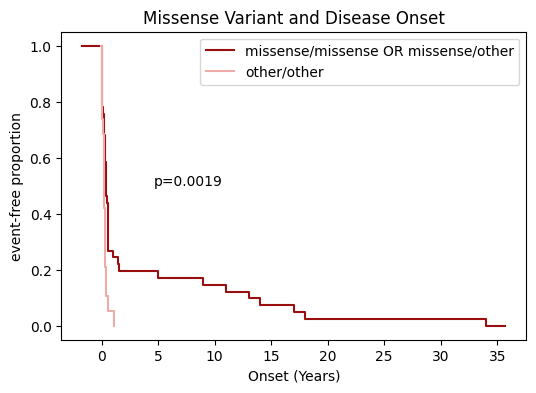

In [16]:
disease_onset_missense_fig, ax = plt.subplots(figsize=(6, 4))

_ = ax.xaxis.set(
    # Show X axis in years ...
    major_formatter=mpl.ticker.FuncFormatter(lambda x, pos: f"{x / Age.DAYS_IN_YEAR:.0f}"),
    # ... with a tick for every 5 years
    major_locator=mpl.ticker.MultipleLocator(5 * Age.DAYS_IN_YEAR),
)

# Add labels
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Missense Variant and Disease Onset")
ax.text(1700, 0.5, f"p={missense_onset_result.pval:.4f}")

plt.tight_layout()
missense_onset_result.plot_kaplan_meier_curves(ax=ax)

# Summary

In [17]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=p98l_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=arg50gln_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    )
)

M_results = (
    GPAnalysisResultSummary.from_mono(
        result=p98l_mortality_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result,
    )
)

caption = """No clear genotype-phenotype correlation exists. However, a trend for longer survival 
can be observed in individuals with biallelic pathogenic missense variants compared to individuals with biallelic null\\cite{PMID_20074988,PMID_22593919}.
"""

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             mono_results=M_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)


In [18]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [19]:
summarizer.process_latex(report=report, protein_fig=mpv17_fig, stats_fig=disease_onset_missense_fig)

Figure saved to ../../supplement/img/MPV17_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/MPV17_stats-draft.pdf
Output to ../../supplement/tex/MPV17_summary_draft.tex
